### Manipulation of Trans Proteomic Pipeline (TPP) Comet database search results of *Prochlorococus MED4* LC-MS/MS data using python.

Starting with: 

- Comet output (.xlxs and .csv) of PTM-optimized database searches, sorted by XCorr (descending)

Ending with:

- Files with stripped (no PTMs or tryptic ends) peptide lists and
- Columns with #'s of each modification in every sequence
- Column with stripped peptide lengths (# amino acids)
- Histogram of sequence lengths
- Bar plots of PTM occurance

### To use:

#### 1. Change the input file name in *IN 4*
#### 2. Change output file name in *IN 6*, *IN 7*, *IN 8*

For technical duplicates, I exported Comet search results as both Excel files and as CSVs into my ETNP 2017 git repo:

In [2]:
cd /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/

/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP


In [3]:
ls

RAL4_MED2_trypsin_1_PTMopt_Comet.csv
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped.csv
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped_peptides_2.5XCorr.txt
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped_peptides.txt
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped_work.ods
RAL4_MED2_trypsin_1_PTMopt_Comet.xlsx
RAL4_MED2_trypsin_1_PTMopt_PepProp90.csv
RAL4_MED2_trypsin_1_PTMopt_PepProp90_stripped.csv
RAL4_MED2_trypsin_1_PTMopt_PepProp90_stripped_peptides
RAL4_MED2_trypsin_1_PTMopt_PepProp90.xlsx
RAL4_MED2_trypsin_2_PTMopt_Comet.csv
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped.csv
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped_peptides_2.5XCorr.txt
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped_peptides.txt
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped_work.ods
RAL4_MED2_trypsin_2_PTMopt_Comet.xlsx
RAL4_MED2_trypsin_2_PTMopt_PepProp90.csv
RAL4_MED2_trypsin_2_PTMopt_PepProp90_stripped.csv
RAL4_MED2_trypsin_2_PTMopt_PepProp90_stripped_peptides
RAL4_MED2_trypsin_2_PTMopt_PepProp90.xlsx


In [4]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

In [8]:
#read the CSVs of each replicate into a datadrame we name 'comet' using the pandas read_csv function
comet1 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_1_PTMopt_Comet.csv")
comet2 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_2_PTMopt_Comet.csv")

frames = [comet1, comet2]

# concatenate dataframes
cometdup = pd.concat(frames, sort=False)

# remove redundant rows
# actually, this won't work since the file name will be different and spectrum #. We'll deduplicate later but I'll leave this for now. 
comet = pd.DataFrame.drop_duplicates(cometdup)

print("# redundant Comet peptides in combined dataframe", len(cometdup))
print("# nonredundant Comet peptides in combined dataframe", len(comet))

#look at the dataframe
comet.head()

# redundant Comet peptides in combined dataframe 118797
# nonredundant Comet peptides in combined dataframe 118797


,spectrum,xcorr,deltacn,expect,ions,peptide,protein,calc_neutral_pep_mass
0,022016_RAL4_95_MED2_trypsin_1.41211.41211.4,8.768,1,1.42E-09,22/156,K.LFADENHLSPAVTAIQIEDIDAEQFRK.N,PMM0035,3069.5407
1,022016_RAL4_95_MED2_trypsin_1.32793.32793.4,8.578,1,9.31E-10,18/204,K.LAIDDSSIN[115.03]LDQVDYIN[115.03]AHGTSTTANDK...,PMM1609,3735.7599
2,022016_RAL4_95_MED2_trypsin_1.50751.50751.4,8.469,0.646,3.43E-14,24/156,R.SGLQNAASIAGM[147.04]VLTTEC[160.03]IVADLPEKK.D,PMM1436,2831.4409
3,022016_RAL4_95_MED2_trypsin_1.31065.31065.3,8.061,0.561,2.18E-11,17/92,K.IDIEDGGIVTIASHDGAAAEEAQK.I,PMM1191,2409.166
4,022016_RAL4_95_MED2_trypsin_1.50278.50278.4,7.949,0.584,3.02E-09,23/156,R.SGLQNAASIAGM[147.04]VLTTEC[160.03]IVADLPEKK.D,PMM1436,2831.4409


The peptide column has the residues before and after the tryptic terminii as well as masses of modified residues (e.g., 160.03 Da for carbamidomethylated cysteine). We want to make new columns with all that information and make a column with only the 'stripped' peptide sequence that's just amino acids - this we can then align against other sequences, for example. 

Modified residues were allowed for:

- fixed carbamodimethylation of cysteine 57.021464 C
- varialbe oxidation of methionine: 15.9949 M
- variable deamidation of asparagine, glumatine: 0.984016 NQ
- variable iron cation on lysine: 54.010565 K
- variable methylation of lysine and arginine: 14.015650 KR

We'll then write this manipulated dataframe to a new file.

In [9]:
# get rid of rows where the xcorr is unavailable (usually 3 or so)
comet = comet[comet.xcorr != '[unavailable]']

# use str.strip with indexing by str[0] to add a column with the peptide's left terminus
comet['L terminus'] = comet['peptide'].astype(str).str[0]

# use str.strip with indexing by str[-1] to add a column with the peptide's left terminus
comet['R terminus'] = comet['peptide'].str.strip().str[-1]

# use a count function to enumerate the # of ccarbamidomethylated C's in each peptide
comet['c-carb'] = comet['peptide'].str.count("160.03")

# use a count function to enumerate the # of oxidized M's in each peptide
comet['m-oxid'] = comet['peptide'].str.count("147.04")

# use a count function to enumerate the # of deamidated N's in each peptide
comet['n-deam'] = comet['peptide'].str.count("115.03")

# use a count function to enumerate the # of deamidated Q's in each peptide
comet['q-deam'] = comet['peptide'].str.count("129.04")

# use a count function to enumerate the # of iron adducted K's in each peptide
comet['k-iron'] = comet['peptide'].str.count("182.11")

# use a count function to enumerate the # of methylated K's in each peptide
comet['k-meth'] = comet['peptide'].str.count("142.11")

# use a count function to enumerate the # of methylated R's in each peptide
comet['r-meth'] = comet['peptide'].str.count("170.12")

# create a column with 'stripped' peptide sequences using strip
comet['stripped peptide'] = comet['peptide'].str[2:].str[:-2].str.replace(r"\[.*\]","")

# add a column with the stripped peptide length (number of AAs)
comet['stripped length'] = comet['stripped peptide'].apply(len)

# total the number of modifications in sequence
comet['ptm-total'] = comet['c-carb'] + comet['m-oxid'] + comet['n-deam'] + comet['q-deam'] + comet['k-iron'] + comet['k-meth'] + comet['r-meth']

# total the number of modifications in sequence relative to # of AAs
comet['ptm-norm'] = comet['ptm-total'] / comet['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
comet.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_1_PTMopt_Comet_stripped.csv")


# check out the results
comet.head(20)

,spectrum,xcorr,deltacn,expect,ions,peptide,protein,calc_neutral_pep_mass,L terminus,R terminus,...,m-oxid,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,ptm-total,ptm-norm
0,022016_RAL4_95_MED2_trypsin_1.41211.41211.4,8.768,1,1.42E-09,22/156,K.LFADENHLSPAVTAIQIEDIDAEQFRK.N,PMM0035,3069.5407,K,N,...,0,0,0,0,0,0,LFADENHLSPAVTAIQIEDIDAEQFRK,27,0,0.000000
1,022016_RAL4_95_MED2_trypsin_1.32793.32793.4,8.578,1,9.31E-10,18/204,K.LAIDDSSIN[115.03]LDQVDYIN[115.03]AHGTSTTANDK...,PMM1609,3735.7599,K,S,...,0,2,0,0,0,0,LAIDDSSINAHGTSTTANDKNETSAIK,27,2,0.074074
2,022016_RAL4_95_MED2_trypsin_1.50751.50751.4,8.469,0.646,3.43E-14,24/156,R.SGLQNAASIAGM[147.04]VLTTEC[160.03]IVADLPEKK.D,PMM1436,2831.4409,R,D,...,1,0,0,0,0,0,SGLQNAASIAGMIVADLPEKK,21,2,0.095238
3,022016_RAL4_95_MED2_trypsin_1.31065.31065.3,8.061,0.561,2.18E-11,17/92,K.IDIEDGGIVTIASHDGAAAEEAQK.I,PMM1191,2409.166,K,I,...,0,0,0,0,0,0,IDIEDGGIVTIASHDGAAAEEAQK,24,0,0.000000
4,022016_RAL4_95_MED2_trypsin_1.50278.50278.4,7.949,0.584,3.02E-09,23/156,R.SGLQNAASIAGM[147.04]VLTTEC[160.03]IVADLPEKK.D,PMM1436,2831.4409,R,D,...,1,0,0,0,0,0,SGLQNAASIAGMIVADLPEKK,21,2,0.095238
5,022016_RAL4_95_MED2_trypsin_1.26579.26579.3,7.813,0.516,2.22E-05,18/68,R.DKGSLVLLDAC[160.03]QSLAHQK.L,PMM0070,1982.0255,R,L,...,0,0,0,0,0,0,DKGSLVLLDACQSLAHQK,18,1,0.055556
6,022016_RAL4_95_MED2_trypsin_1.50978.50978.4,7.753,0.597,1.82E-08,21/156,R.SGLQNAASIAGM[147.04]VLTTEC[160.03]IVADLPEKK.D,PMM1436,2831.4409,R,D,...,1,0,0,0,0,0,SGLQNAASIAGMIVADLPEKK,21,2,0.095238
7,022016_RAL4_95_MED2_trypsin_1.61470.61470.4,7.744,0.529,1.13E-09,18/156,R.SGLQNAASIAGMVLTTEC[160.03]IVADLPEKK.D,PMM1436,2815.446,R,D,...,0,0,0,0,0,0,SGLQNAASIAGMVLTTECIVADLPEKK,27,1,0.037037
8,022016_RAL4_95_MED2_trypsin_1.61687.61687.4,7.673,0.61,1.77E-11,23/156,R.SGLQNAASIAGMVLTTEC[160.03]IVADLPEKK.D,PMM1436,2815.446,R,D,...,0,0,0,0,0,0,SGLQNAASIAGMVLTTECIVADLPEKK,27,1,0.037037
9,022016_RAL4_95_MED2_trypsin_1.31081.31081.2,7.56,0.629,3.14E-12,15/46,K.IDIEDGGIVTIASHDGAAAEEAQK.I,PMM1191,2409.166,K,I,...,0,0,0,0,0,0,IDIEDGGIVTIASHDGAAAEEAQK,24,0,0.000000


In [11]:
# keep only stripped peptide column
pep = comet[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_combine_PTMopt_Comet_stripped_peptides.txt", header=False, index=False)


# look

print("# redundant Comet peptides", len(pep))
print("Max Xcorr: ", comet['xcorr'].max())
print("Min Xcorr: ", comet['xcorr'].min())

pep.head()

# redundant Comet peptides 115289
Max Xcorr:  8.78
Min Xcorr:  0.001


,stripped peptide
0,LFADENHLSPAVTAIQIEDIDAEQFRK
1,LAIDDSSINAHGTSTTANDKNETSAIK
2,SGLQNAASIAGMIVADLPEKK
3,IDIEDGGIVTIASHDGAAAEEAQK
4,SGLQNAASIAGMIVADLPEKK


### Filtering PSMs > XCorr 2.5

In [12]:
# keep only peptides  >2.5 XCorr
# need to convert Xcorr column from strings to numeric so we can use loc
comet['xcorr'] = pd.to_numeric(comet['xcorr'])

comet25 = comet.loc[comet['xcorr'] >= 2.5]


# keep only peptide column 
pep25 = comet25[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep25.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_combine_PTMopt_Comet_stripped_peptides_2.5XCorr.txt", header=False, index=False)


print("# redundant Comet peptides >2.5 XCorr", len(pep25))
pep25.head()

# redundant Comet peptides >2.5 XCorr 37201


,stripped peptide
0,LFADENHLSPAVTAIQIEDIDAEQFRK
1,LAIDDSSINAHGTSTTANDKNETSAIK
2,SGLQNAASIAGMIVADLPEKK
3,IDIEDGGIVTIASHDGAAAEEAQK
4,SGLQNAASIAGMIVADLPEKK


In [26]:
# removing redundancy
comet25dedup = pd.DataFrame.drop_duplicates(pep25)

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

comet25dedup.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_combine_PTMopt_Comet_stripped__nonredundant_peptides_2.5XCorr.txt", header=False, index=False)

print("# nonredundant Comet peptides", len(comet25dedup))
comet25dedup.head()

# nonredundant Comet peptides 13117


,stripped peptide
0,LFADENHLSPAVTAIQIEDIDAEQFRK
1,LAIDDSSINAHGTSTTANDKNETSAIK
2,SGLQNAASIAGMIVADLPEKK
3,IDIEDGGIVTIASHDGAAAEEAQK
5,DKGSLVLLDACQSLAHQK


### All XCorr - Visualizing the results:

Text(0.5, 1.0, 'Arginine methylation')

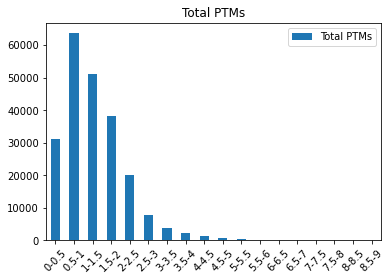

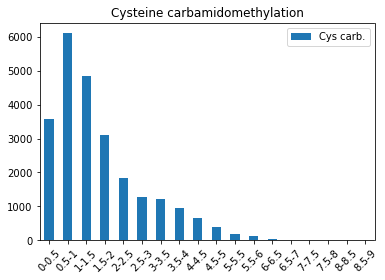

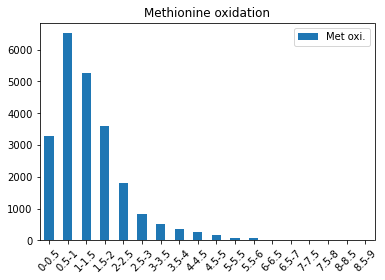

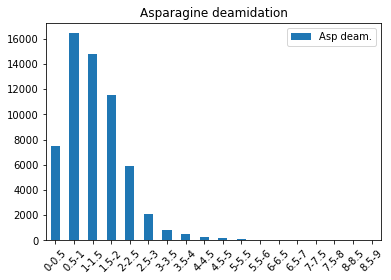

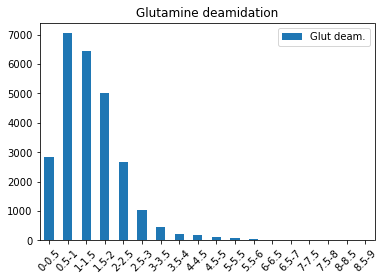

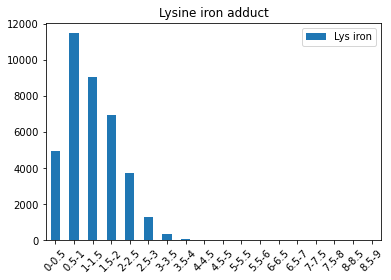

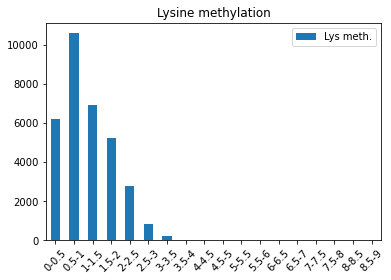

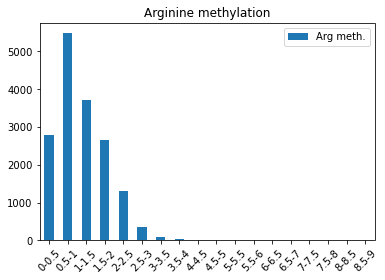

In [13]:
# making evenly spaced bins for the Xcorr data based on the min and max, called above
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]
labels = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5', '5-5.5', '5.5-6', '6-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-9']

# use pandas cut function to do the binning itself
comet['binned'] = pd.cut(comet['xcorr'], bins=bins, labels=labels)

# bar plots of binned PTM data

index = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5', '5-5.5', '5.5-6', '6-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-9']
data = {'Total PTMs': [comet.groupby('binned')['ptm-total'].sum()['0-0.5'], comet.groupby('binned')['ptm-total'].sum()['0.5-1'], comet.groupby('binned')['ptm-total'].sum()['1-1.5'], comet.groupby('binned')['ptm-total'].sum()['1.5-2'], comet.groupby('binned')['ptm-total'].sum()['2-2.5'], comet.groupby('binned')['ptm-total'].sum()['2.5-3'], comet.groupby('binned')['ptm-total'].sum()['3-3.5'], comet.groupby('binned')['ptm-total'].sum()['3.5-4'], comet.groupby('binned')['ptm-total'].sum()['4-4.5'], comet.groupby('binned')['ptm-total'].sum()['4.5-5'], comet.groupby('binned')['ptm-total'].sum()['5-5.5'], comet.groupby('binned')['ptm-total'].sum()['5.5-6'], comet.groupby('binned')['ptm-total'].sum()['6-6.5'], comet.groupby('binned')['ptm-total'].sum()['6.5-7'], comet.groupby('binned')['ptm-total'].sum()['7-7.5'], comet.groupby('binned')['ptm-total'].sum()['7.5-8'], comet.groupby('binned')['ptm-total'].sum()['8-8.5'], comet.groupby('binned')['ptm-total'].sum()['8.5-9']],
        'Cys carb.': [comet.groupby('binned')['c-carb'].sum()['0-0.5'], comet.groupby('binned')['c-carb'].sum()['0.5-1'], comet.groupby('binned')['c-carb'].sum()['1-1.5'], comet.groupby('binned')['c-carb'].sum()['1.5-2'], comet.groupby('binned')['c-carb'].sum()['2-2.5'], comet.groupby('binned')['c-carb'].sum()['2.5-3'], comet.groupby('binned')['c-carb'].sum()['3-3.5'], comet.groupby('binned')['c-carb'].sum()['3.5-4'], comet.groupby('binned')['c-carb'].sum()['4-4.5'], comet.groupby('binned')['c-carb'].sum()['4.5-5'], comet.groupby('binned')['c-carb'].sum()['5-5.5'], comet.groupby('binned')['c-carb'].sum()['5.5-6'], comet.groupby('binned')['c-carb'].sum()['6-6.5'], comet.groupby('binned')['c-carb'].sum()['6.5-7'], comet.groupby('binned')['c-carb'].sum()['7-7.5'], comet.groupby('binned')['c-carb'].sum()['7.5-8'], comet.groupby('binned')['c-carb'].sum()['8-8.5'], comet.groupby('binned')['c-carb'].sum()['8.5-9']],
        'Met oxi.': [comet.groupby('binned')['m-oxid'].sum()['0-0.5'], comet.groupby('binned')['m-oxid'].sum()['0.5-1'], comet.groupby('binned')['m-oxid'].sum()['1-1.5'], comet.groupby('binned')['m-oxid'].sum()['1.5-2'], comet.groupby('binned')['m-oxid'].sum()['2-2.5'], comet.groupby('binned')['m-oxid'].sum()['2.5-3'], comet.groupby('binned')['m-oxid'].sum()['3-3.5'], comet.groupby('binned')['m-oxid'].sum()['3.5-4'], comet.groupby('binned')['m-oxid'].sum()['4-4.5'], comet.groupby('binned')['m-oxid'].sum()['4.5-5'], comet.groupby('binned')['m-oxid'].sum()['5-5.5'], comet.groupby('binned')['m-oxid'].sum()['5.5-6'], comet.groupby('binned')['m-oxid'].sum()['6-6.5'], comet.groupby('binned')['m-oxid'].sum()['6.5-7'], comet.groupby('binned')['m-oxid'].sum()['7-7.5'], comet.groupby('binned')['m-oxid'].sum()['7.5-8'], comet.groupby('binned')['m-oxid'].sum()['8-8.5'], comet.groupby('binned')['m-oxid'].sum()['8.5-9']],
        'Asp deam.': [comet.groupby('binned')['n-deam'].sum()['0-0.5'], comet.groupby('binned')['n-deam'].sum()['0.5-1'], comet.groupby('binned')['n-deam'].sum()['1-1.5'], comet.groupby('binned')['n-deam'].sum()['1.5-2'], comet.groupby('binned')['n-deam'].sum()['2-2.5'], comet.groupby('binned')['n-deam'].sum()['2.5-3'], comet.groupby('binned')['n-deam'].sum()['3-3.5'], comet.groupby('binned')['n-deam'].sum()['3.5-4'], comet.groupby('binned')['n-deam'].sum()['4-4.5'], comet.groupby('binned')['n-deam'].sum()['4.5-5'], comet.groupby('binned')['n-deam'].sum()['5-5.5'], comet.groupby('binned')['n-deam'].sum()['5.5-6'], comet.groupby('binned')['n-deam'].sum()['6-6.5'], comet.groupby('binned')['n-deam'].sum()['6.5-7'], comet.groupby('binned')['n-deam'].sum()['7-7.5'], comet.groupby('binned')['n-deam'].sum()['7.5-8'], comet.groupby('binned')['n-deam'].sum()['8-8.5'], comet.groupby('binned')['n-deam'].sum()['8.5-9']],
        'Glut deam.': [comet.groupby('binned')['q-deam'].sum()['0-0.5'], comet.groupby('binned')['q-deam'].sum()['0.5-1'], comet.groupby('binned')['q-deam'].sum()['1-1.5'], comet.groupby('binned')['q-deam'].sum()['1.5-2'], comet.groupby('binned')['q-deam'].sum()['2-2.5'], comet.groupby('binned')['q-deam'].sum()['2.5-3'], comet.groupby('binned')['q-deam'].sum()['3-3.5'], comet.groupby('binned')['q-deam'].sum()['3.5-4'], comet.groupby('binned')['q-deam'].sum()['4-4.5'], comet.groupby('binned')['q-deam'].sum()['4.5-5'], comet.groupby('binned')['q-deam'].sum()['5-5.5'], comet.groupby('binned')['q-deam'].sum()['5.5-6'], comet.groupby('binned')['q-deam'].sum()['6-6.5'], comet.groupby('binned')['q-deam'].sum()['6.5-7'], comet.groupby('binned')['q-deam'].sum()['7-7.5'], comet.groupby('binned')['q-deam'].sum()['7.5-8'], comet.groupby('binned')['q-deam'].sum()['8-8.5'], comet.groupby('binned')['q-deam'].sum()['8.5-9']],
        'Lys iron': [comet.groupby('binned')['k-iron'].sum()['0-0.5'], comet.groupby('binned')['k-iron'].sum()['0.5-1'], comet.groupby('binned')['k-iron'].sum()['1-1.5'], comet.groupby('binned')['k-iron'].sum()['1.5-2'], comet.groupby('binned')['k-iron'].sum()['2-2.5'], comet.groupby('binned')['k-iron'].sum()['2.5-3'], comet.groupby('binned')['k-iron'].sum()['3-3.5'], comet.groupby('binned')['k-iron'].sum()['3.5-4'], comet.groupby('binned')['k-iron'].sum()['4-4.5'], comet.groupby('binned')['k-iron'].sum()['4.5-5'], comet.groupby('binned')['k-iron'].sum()['5-5.5'], comet.groupby('binned')['k-iron'].sum()['5.5-6'], comet.groupby('binned')['k-iron'].sum()['6-6.5'], comet.groupby('binned')['k-iron'].sum()['6.5-7'], comet.groupby('binned')['k-iron'].sum()['7-7.5'], comet.groupby('binned')['k-iron'].sum()['7.5-8'], comet.groupby('binned')['k-iron'].sum()['8-8.5'], comet.groupby('binned')['k-iron'].sum()['8.5-9']],
        'Lys meth.': [comet.groupby('binned')['k-meth'].sum()['0-0.5'], comet.groupby('binned')['k-meth'].sum()['0.5-1'], comet.groupby('binned')['k-meth'].sum()['1-1.5'], comet.groupby('binned')['k-meth'].sum()['1.5-2'], comet.groupby('binned')['k-meth'].sum()['2-2.5'], comet.groupby('binned')['k-meth'].sum()['2.5-3'], comet.groupby('binned')['k-meth'].sum()['3-3.5'], comet.groupby('binned')['k-meth'].sum()['3.5-4'], comet.groupby('binned')['k-meth'].sum()['4-4.5'], comet.groupby('binned')['k-meth'].sum()['4.5-5'], comet.groupby('binned')['k-meth'].sum()['5-5.5'], comet.groupby('binned')['k-meth'].sum()['5.5-6'], comet.groupby('binned')['k-meth'].sum()['6-6.5'], comet.groupby('binned')['k-meth'].sum()['6.5-7'], comet.groupby('binned')['k-meth'].sum()['7-7.5'], comet.groupby('binned')['k-meth'].sum()['7.5-8'], comet.groupby('binned')['k-meth'].sum()['8-8.5'], comet.groupby('binned')['k-meth'].sum()['8.5-9']],
        'Arg meth.': [comet.groupby('binned')['r-meth'].sum()['0-0.5'], comet.groupby('binned')['r-meth'].sum()['0.5-1'], comet.groupby('binned')['r-meth'].sum()['1-1.5'], comet.groupby('binned')['r-meth'].sum()['1.5-2'], comet.groupby('binned')['r-meth'].sum()['2-2.5'], comet.groupby('binned')['r-meth'].sum()['2.5-3'], comet.groupby('binned')['r-meth'].sum()['3-3.5'], comet.groupby('binned')['r-meth'].sum()['3.5-4'], comet.groupby('binned')['r-meth'].sum()['4-4.5'], comet.groupby('binned')['r-meth'].sum()['4.5-5'], comet.groupby('binned')['r-meth'].sum()['5-5.5'], comet.groupby('binned')['r-meth'].sum()['5.5-6'], comet.groupby('binned')['r-meth'].sum()['6-6.5'], comet.groupby('binned')['r-meth'].sum()['6.5-7'], comet.groupby('binned')['r-meth'].sum()['7-7.5'], comet.groupby('binned')['r-meth'].sum()['7.5-8'], comet.groupby('binned')['r-meth'].sum()['8-8.5'], comet.groupby('binned')['r-meth'].sum()['8.5-9']]
        }

cometbin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys iron', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = cometbin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = cometbin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = cometbin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = cometbin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = cometbin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = cometbin.plot.bar(y='Lys iron', rot=45)
ax6.set_title('Lysine iron adduct')

ax7 = cometbin.plot.bar(y='Lys meth.', rot=45)
ax7.set_title('Lysine methylation')

ax7 = cometbin.plot.bar(y='Arg meth.', rot=45)
ax7.set_title('Arginine methylation')

#plt.savefig('/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/MED4_trypsin1_Comet_PTMopt.png')

<module 'matplotlib.pyplot' from '/home/millieginty/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

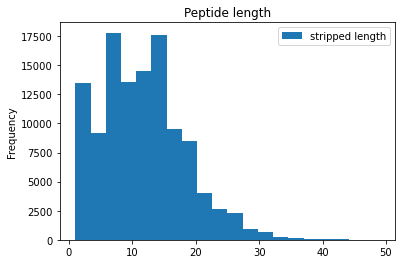

In [14]:
# histogram of stripped peptide lengths

#plt.rcdefaults()
#fig, ax = plt.subplots()

comet.plot(y='stripped length', kind = 'hist', bins = 20, title = 'Peptide length')
plt

<module 'matplotlib.pyplot' from '/home/millieginty/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

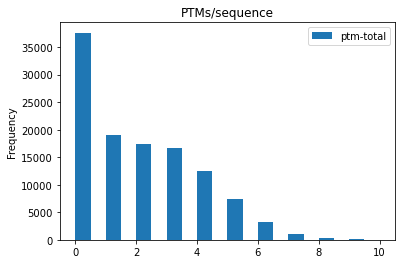

In [19]:
# histogram of total peptide amounts

#plt.rcdefaults()
#fig, ax = plt.subplots()

comet.plot(y='ptm-total', kind = 'hist', bins = 20, title = 'PTMs/sequence')
plt

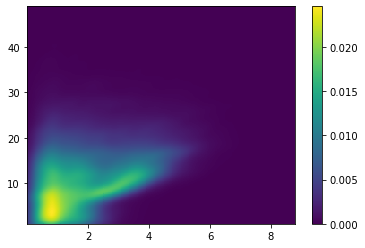

In [16]:
from matplotlib import pyplot
# density plot of xcorr vs length (idea from https://python-graph-gallery.com/85-density-plot-with-matplotlib/)

# read in data
x = comet['xcorr']
y = comet['stripped length']
 
# evaluate a gaussian kernel density estimation (KDE) on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.colorbar()
plt.show() 

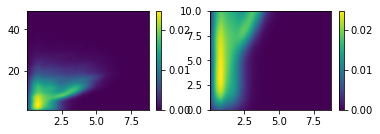

In [18]:
# plot with density of xcorr vs length and xcorr vs total ptms
plt.figure()

# read in data
x = comet['xcorr']
y = comet['stripped length']

a = comet['xcorr']
b = comet['ptm-total']

# evaluate a gaussian kernel density estimation (KDE) on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

c = kde.gaussian_kde([a,b])
ai, bi = np.mgrid[a.min():a.max():nbins*1j, b.min():b.max():nbins*1j]
di = k(np.vstack([ai.flatten(), bi.flatten()]))

# density plot of length vs xcorr
plt.subplot(221)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.title('logit')
plt.colorbar()

# density plot of xcorr vs ptms
plt.subplot(222)
plt.pcolormesh(ai, bi, di.reshape(ai.shape))
plt.title('Combined MED4 Comet XCorr vs total PTMs')
plt.colorbar()


plt.show()

### XCorr > 2.5 - Visualizing the results:

<ipython-input-20-49fc43bb61b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comet25['binned'] = pd.cut(comet25['xcorr'], bins=bins, labels=labels)


Text(0.5, 1.0, 'Arginine methylation')

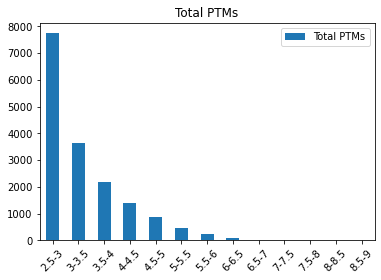

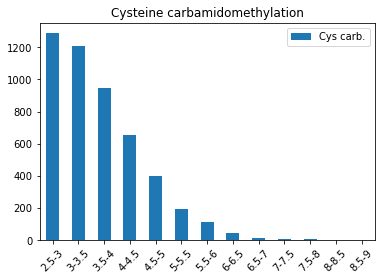

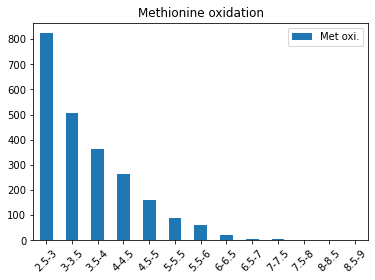

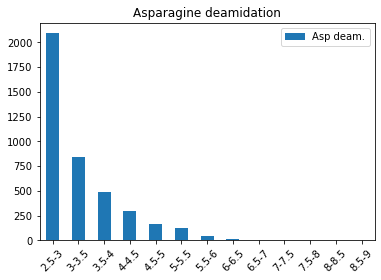

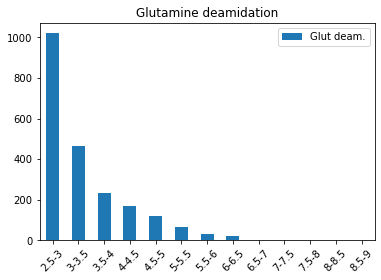

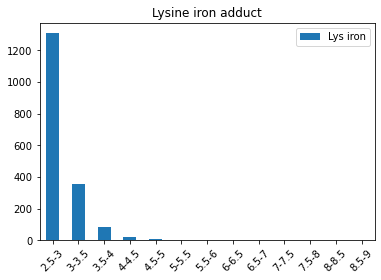

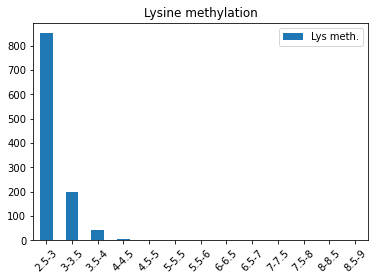

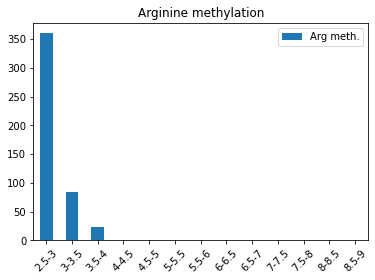

In [20]:
# making evenly spaced bins for the Xcorr data based on the min and max, called above
bins = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9]
labels = ['2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5', '5-5.5', '5.5-6', '6-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-9']

# use pandas cut function to do the binning itself
comet25['binned'] = pd.cut(comet25['xcorr'], bins=bins, labels=labels)

# bar plots of binned PTM data

index = ['2.5-3', '3-3.5', '3.5-4', '4-4.5', '4.5-5', '5-5.5', '5.5-6', '6-6.5', '6.5-7', '7-7.5', '7.5-8', '8-8.5', '8.5-9']
data = {'Total PTMs': [comet25.groupby('binned')['ptm-total'].sum()['2.5-3'], comet25.groupby('binned')['ptm-total'].sum()['3-3.5'], comet25.groupby('binned')['ptm-total'].sum()['3.5-4'], comet25.groupby('binned')['ptm-total'].sum()['4-4.5'], comet25.groupby('binned')['ptm-total'].sum()['4.5-5'], comet25.groupby('binned')['ptm-total'].sum()['5-5.5'], comet25.groupby('binned')['ptm-total'].sum()['5.5-6'], comet25.groupby('binned')['ptm-total'].sum()['6-6.5'], comet25.groupby('binned')['ptm-total'].sum()['6.5-7'], comet25.groupby('binned')['ptm-total'].sum()['7-7.5'], comet25.groupby('binned')['ptm-total'].sum()['7.5-8'], comet25.groupby('binned')['ptm-total'].sum()['8-8.5'], comet25.groupby('binned')['ptm-total'].sum()['8.5-9']],
        'Cys carb.': [comet25.groupby('binned')['c-carb'].sum()['2.5-3'], comet25.groupby('binned')['c-carb'].sum()['3-3.5'], comet25.groupby('binned')['c-carb'].sum()['3.5-4'], comet25.groupby('binned')['c-carb'].sum()['4-4.5'], comet25.groupby('binned')['c-carb'].sum()['4.5-5'], comet25.groupby('binned')['c-carb'].sum()['5-5.5'], comet25.groupby('binned')['c-carb'].sum()['5.5-6'], comet25.groupby('binned')['c-carb'].sum()['6-6.5'], comet25.groupby('binned')['c-carb'].sum()['6.5-7'], comet25.groupby('binned')['c-carb'].sum()['7-7.5'], comet25.groupby('binned')['c-carb'].sum()['7.5-8'], comet25.groupby('binned')['c-carb'].sum()['8-8.5'], comet25.groupby('binned')['c-carb'].sum()['8.5-9']],
        'Met oxi.': [comet25.groupby('binned')['m-oxid'].sum()['2.5-3'], comet25.groupby('binned')['m-oxid'].sum()['3-3.5'], comet25.groupby('binned')['m-oxid'].sum()['3.5-4'], comet25.groupby('binned')['m-oxid'].sum()['4-4.5'], comet25.groupby('binned')['m-oxid'].sum()['4.5-5'], comet25.groupby('binned')['m-oxid'].sum()['5-5.5'], comet25.groupby('binned')['m-oxid'].sum()['5.5-6'], comet25.groupby('binned')['m-oxid'].sum()['6-6.5'], comet25.groupby('binned')['m-oxid'].sum()['6.5-7'], comet25.groupby('binned')['m-oxid'].sum()['7-7.5'], comet25.groupby('binned')['m-oxid'].sum()['7.5-8'], comet25.groupby('binned')['m-oxid'].sum()['8-8.5'], comet25.groupby('binned')['m-oxid'].sum()['8.5-9']],
        'Asp deam.': [comet25.groupby('binned')['n-deam'].sum()['2.5-3'], comet25.groupby('binned')['n-deam'].sum()['3-3.5'], comet25.groupby('binned')['n-deam'].sum()['3.5-4'], comet25.groupby('binned')['n-deam'].sum()['4-4.5'], comet25.groupby('binned')['n-deam'].sum()['4.5-5'], comet25.groupby('binned')['n-deam'].sum()['5-5.5'], comet25.groupby('binned')['n-deam'].sum()['5.5-6'], comet25.groupby('binned')['n-deam'].sum()['6-6.5'], comet25.groupby('binned')['n-deam'].sum()['6.5-7'], comet25.groupby('binned')['n-deam'].sum()['7-7.5'], comet25.groupby('binned')['n-deam'].sum()['7.5-8'], comet25.groupby('binned')['n-deam'].sum()['8-8.5'], comet25.groupby('binned')['n-deam'].sum()['8.5-9']],
        'Glut deam.': [comet25.groupby('binned')['q-deam'].sum()['2.5-3'], comet25.groupby('binned')['q-deam'].sum()['3-3.5'], comet25.groupby('binned')['q-deam'].sum()['3.5-4'], comet25.groupby('binned')['q-deam'].sum()['4-4.5'], comet25.groupby('binned')['q-deam'].sum()['4.5-5'], comet25.groupby('binned')['q-deam'].sum()['5-5.5'], comet25.groupby('binned')['q-deam'].sum()['5.5-6'], comet25.groupby('binned')['q-deam'].sum()['6-6.5'], comet25.groupby('binned')['q-deam'].sum()['6.5-7'], comet25.groupby('binned')['q-deam'].sum()['7-7.5'], comet25.groupby('binned')['q-deam'].sum()['7.5-8'], comet25.groupby('binned')['q-deam'].sum()['8-8.5'], comet25.groupby('binned')['q-deam'].sum()['8.5-9']],
        'Lys iron': [comet25.groupby('binned')['k-iron'].sum()['2.5-3'], comet25.groupby('binned')['k-iron'].sum()['3-3.5'], comet25.groupby('binned')['k-iron'].sum()['3.5-4'], comet25.groupby('binned')['k-iron'].sum()['4-4.5'], comet25.groupby('binned')['k-iron'].sum()['4.5-5'], comet25.groupby('binned')['k-iron'].sum()['5-5.5'], comet25.groupby('binned')['k-iron'].sum()['5.5-6'], comet25.groupby('binned')['k-iron'].sum()['6-6.5'], comet25.groupby('binned')['k-iron'].sum()['6.5-7'], comet25.groupby('binned')['k-iron'].sum()['7-7.5'], comet25.groupby('binned')['k-iron'].sum()['7.5-8'], comet25.groupby('binned')['k-iron'].sum()['8-8.5'], comet25.groupby('binned')['k-iron'].sum()['8.5-9']],
        'Lys meth.': [comet25.groupby('binned')['k-meth'].sum()['2.5-3'], comet25.groupby('binned')['k-meth'].sum()['3-3.5'], comet25.groupby('binned')['k-meth'].sum()['3.5-4'], comet25.groupby('binned')['k-meth'].sum()['4-4.5'], comet25.groupby('binned')['k-meth'].sum()['4.5-5'], comet25.groupby('binned')['k-meth'].sum()['5-5.5'], comet25.groupby('binned')['k-meth'].sum()['5.5-6'], comet25.groupby('binned')['k-meth'].sum()['6-6.5'], comet25.groupby('binned')['k-meth'].sum()['6.5-7'], comet25.groupby('binned')['k-meth'].sum()['7-7.5'], comet25.groupby('binned')['k-meth'].sum()['7.5-8'], comet25.groupby('binned')['k-meth'].sum()['8-8.5'], comet25.groupby('binned')['k-meth'].sum()['8.5-9']],
        'Arg meth.': [comet25.groupby('binned')['r-meth'].sum()['2.5-3'], comet25.groupby('binned')['r-meth'].sum()['3-3.5'], comet25.groupby('binned')['r-meth'].sum()['3.5-4'], comet25.groupby('binned')['r-meth'].sum()['4-4.5'], comet25.groupby('binned')['r-meth'].sum()['4.5-5'], comet25.groupby('binned')['r-meth'].sum()['5-5.5'], comet25.groupby('binned')['r-meth'].sum()['5.5-6'], comet25.groupby('binned')['r-meth'].sum()['6-6.5'], comet25.groupby('binned')['r-meth'].sum()['6.5-7'], comet25.groupby('binned')['r-meth'].sum()['7-7.5'], comet25.groupby('binned')['r-meth'].sum()['7.5-8'], comet25.groupby('binned')['r-meth'].sum()['8-8.5'], comet25.groupby('binned')['r-meth'].sum()['8.5-9']]
        }

comet25bin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys iron', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = comet25bin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = comet25bin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = comet25bin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = comet25bin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = comet25bin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = comet25bin.plot.bar(y='Lys iron', rot=45)
ax6.set_title('Lysine iron adduct')

ax7 = comet25bin.plot.bar(y='Lys meth.', rot=45)
ax7.set_title('Lysine methylation')

ax7 = comet25bin.plot.bar(y='Arg meth.', rot=45)
ax7.set_title('Arginine methylation')

#plt.savefig('/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/MED4_trypsin1_comet25_PTMopt.png')

<module 'matplotlib.pyplot' from '/home/millieginty/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

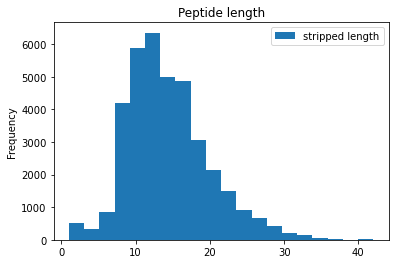

In [21]:
# histogram of stripped peptide lengths

#plt.rcdefaults()
#fig, ax = plt.subplots()

comet25.plot(y='stripped length', kind = 'hist', bins = 20, title = 'Peptide length')
plt

<module 'matplotlib.pyplot' from '/home/millieginty/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

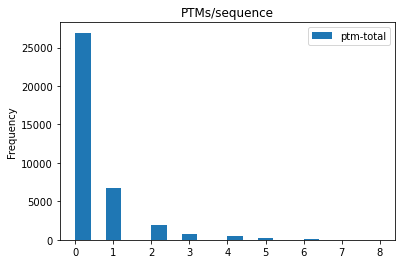

In [22]:
# histogram of total peptide amounts

#plt.rcdefaults()
#fig, ax = plt.subplots()

comet25.plot(y='ptm-total', kind = 'hist', bins = 20, title = 'PTMs/sequence')
plt

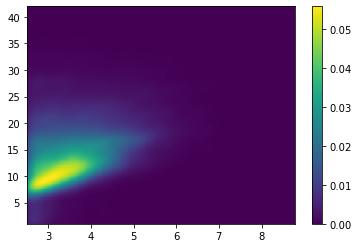

In [27]:
from matplotlib import pyplot
# density plot of xcorr vs length (idea from https://python-graph-gallery.com/85-density-plot-with-matplotlib/)

# read in data
x = comet25['xcorr']
y = comet25['stripped length']
 
# evaluate a gaussian kernel density estimation (KDE) on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.colorbar()
plt.show() 

In [29]:
# now we have the stripped peptide csvs and txt files in the same data dir:
!ls /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/

RAL4_MED2_trypsin_1_PTMopt_Comet.csv
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped.csv
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped_peptides_2.5XCorr.txt
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped_peptides.txt
RAL4_MED2_trypsin_1_PTMopt_Comet_stripped_work.ods
RAL4_MED2_trypsin_1_PTMopt_Comet.xlsx
RAL4_MED2_trypsin_1_PTMopt_PepProp90.csv
RAL4_MED2_trypsin_1_PTMopt_PepProp90_stripped.csv
RAL4_MED2_trypsin_1_PTMopt_PepProp90_stripped_peptides
RAL4_MED2_trypsin_1_PTMopt_PepProp90.xlsx
RAL4_MED2_trypsin_2_PTMopt_Comet.csv
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped.csv
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped_peptides_2.5XCorr.txt
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped_peptides.txt
RAL4_MED2_trypsin_2_PTMopt_Comet_stripped_work.ods
RAL4_MED2_trypsin_2_PTMopt_Comet.xlsx
RAL4_MED2_trypsin_2_PTMopt_PepProp90.csv
RAL4_MED2_trypsin_2_PTMopt_PepProp90_stripped.csv
RAL4_MED2_trypsin_2_PTMopt_PepProp90_stripped_peptides
RAL4_MED2_trypsin_2_PTMopt_PepProp90.xlsx
RAL4_MED2_trypsin_combine_PTMopt_Comet_str